<a href="https://colab.research.google.com/github/co1dtype/face_recog0902/blob/main/Noisy_code_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Make Noisying Data

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}
plt.rcParams['figure.figsize'] = 8,8

from scipy.ndimage.interpolation import zoom
from tensorflow.keras.preprocessing.image import load_img, img_to_array
# from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
# from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

import matplotlib.cm as cm
import numpy as np
import os
from scipy.ndimage.interpolation import zoom
import numpy as np
from matplotlib.pyplot import figure
from tensorflow.keras import backend
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tqdm.notebook import tqdm
import cv2
# from PIL import Image 
from IPython.display import Image, display
import IPython
from tensorflow.keras.applications.vgg16 import VGG16
import numpy as np
import pickle
import matplotlib.pyplot as plt
import keras
import cv2
import IPython.display as display

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}
plt.rcParams['figure.figsize'] = 8,8

from scipy.ndimage.interpolation import zoom
from tensorflow.keras.preprocessing.image import load_img, img_to_array
# from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
# from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

from PIL import Image

# import PIL
import tensorflow as tf
#import keras as K
# import PIL
import tensorflow as tf
#import keras as K

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
with open('/content/gdrive/My Drive/file.txt', 'w') as f:
  f.write('content')

## Dataload & function compile 

In [3]:
train_data = np.load("/content/drive/MyDrive/Lab/data_list_mid.npy")
train_label = np.load("/content/drive/MyDrive/Lab/data_label_mid.npy")
# test_data = np.load("test_data_list_mid.npy")
# test_label = np.load("test_data_label_mid.npy")
# val_data = np.load("val_data_list_mid.npy")
# val_label = np.load("val_data_label_mid.npy")


In [ ]:
train_data.shape

(13500, 112, 112, 3)

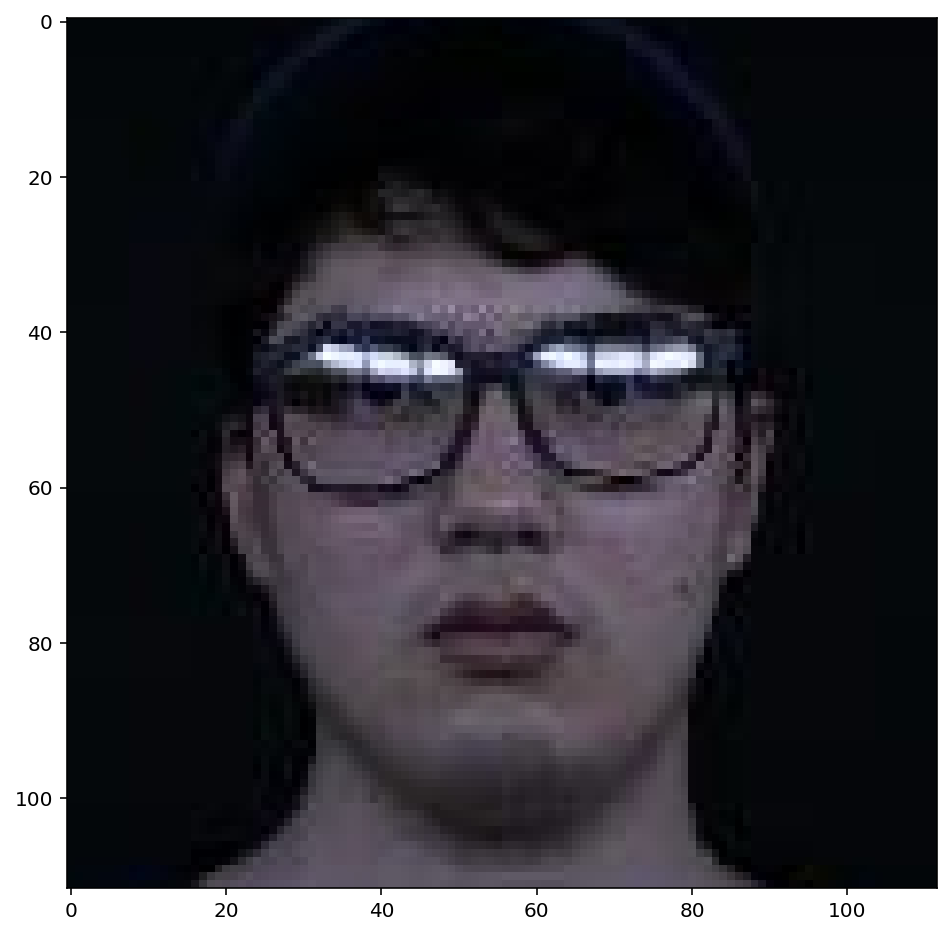

In [ ]:
plt.imshow(train_data[44])

In [ ]:
train_data.shape

(13500, 112, 112, 3)

In [4]:
def split_channel (img):
    height,width,channels = img.shape
    red_pixels=[]
    green_pixels=[]
    blue_pixels=[]

    for h in range(height):
        tmp_red = []
        tmp_green = []
        tmp_blue = []
        for w in range(width):
            tmp_red.append(img[h][w][0])
            tmp_green.append(img[h][w][1])
            tmp_blue.append(img[h][w][2])
        red_pixels.append(tmp_red)
        green_pixels.append(tmp_green)
        blue_pixels.append(tmp_blue)
        
    return np.array(red_pixels), np.array(green_pixels), np.array(blue_pixels)

In [5]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size, interpolation = "nearest")
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array
# img = get_img_array(img_path, size = (112,112,3))

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    global a1
    a1 = grad_model

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_array, heatmap, cam_path="cam.jpg", alpha=0.01):
    # Load the original image
    
    img = img_array

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)
    print(np.array(superimposed_img).shape)
    # Display Grad CAM
    
    display(Image(cam_path,width = 300, height = 300))
    
def gradCam_Array(img_array, heatmap, cam_path="cam.jpg", alpha=0.01):
    img = img_array

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    return np.array(superimposed_img)


### Add random Noisy

In [6]:
pb_path =  '/content/drive/MyDrive/Lab/0816'
model = tf.keras.models.load_model(pb_path)

In [7]:
layers = [
    'block0_conv0',
    'block0_conv1',
    'block1_conv0',
    'block1_conv1',
    'block2_conv0',
    'block2_conv1',
    'block2_conv2',
    'block3_conv0',
    'block3_conv1',
    'block3_conv2',
    'block4_conv0',
    'block4_conv1',
    'block4_conv2'
]

In [ ]:
model.summary()

Model: "functional_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 112, 112, 3)]     0         
                                                                 
 block0_conv0 (Conv2D)       (None, 112, 112, 64)      1792      
                                                                 
 block0_conv1 (Conv2D)       (None, 112, 112, 64)      36928     
                                                                 
 block0_pooling (MaxPooling2  (None, 56, 56, 64)       0         
 D)                                                              
                                                                 
 block1_conv0 (Conv2D)       (None, 56, 56, 128)       73856     
                                                                 
 block1_conv1 (Conv2D)       (None, 56, 56, 128)       147584    
                                                      

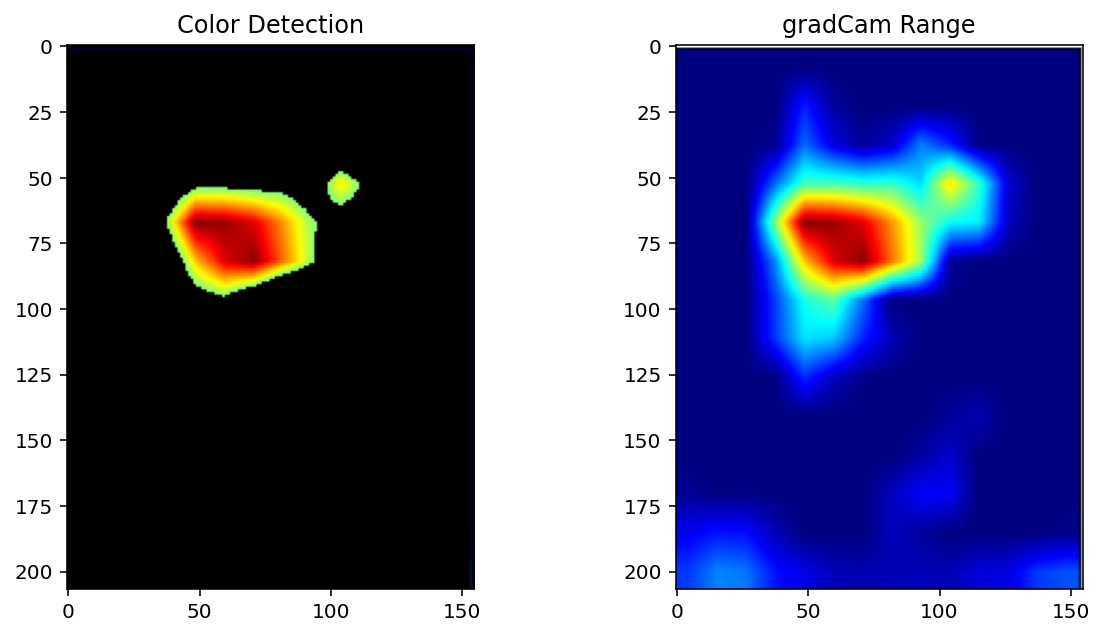

In [ ]:
img = np.asarray(Image.open("/content/drive/MyDrive/Lab/gradCam_colormap.png"))

fig = plt.figure(figsize=(10, 5))
rows = 1; cols = 2

dst1 = cv2.inRange(img, (0, 0, 0), (300, 300, 125)) # B : 0 ~ 150, G : 0 ~ 150, R : 100 ~ 255
img_result = cv2.bitwise_and(img, img, mask = dst1)

ax1 = fig.add_subplot(rows, cols, 1)
ax1.set_title('Color Detection')
image1 = ax1.imshow(img_result)

ax2 = fig.add_subplot(rows, cols, 2)
ax2.set_title('gradCam Range')
image2 = ax2.imshow(img)

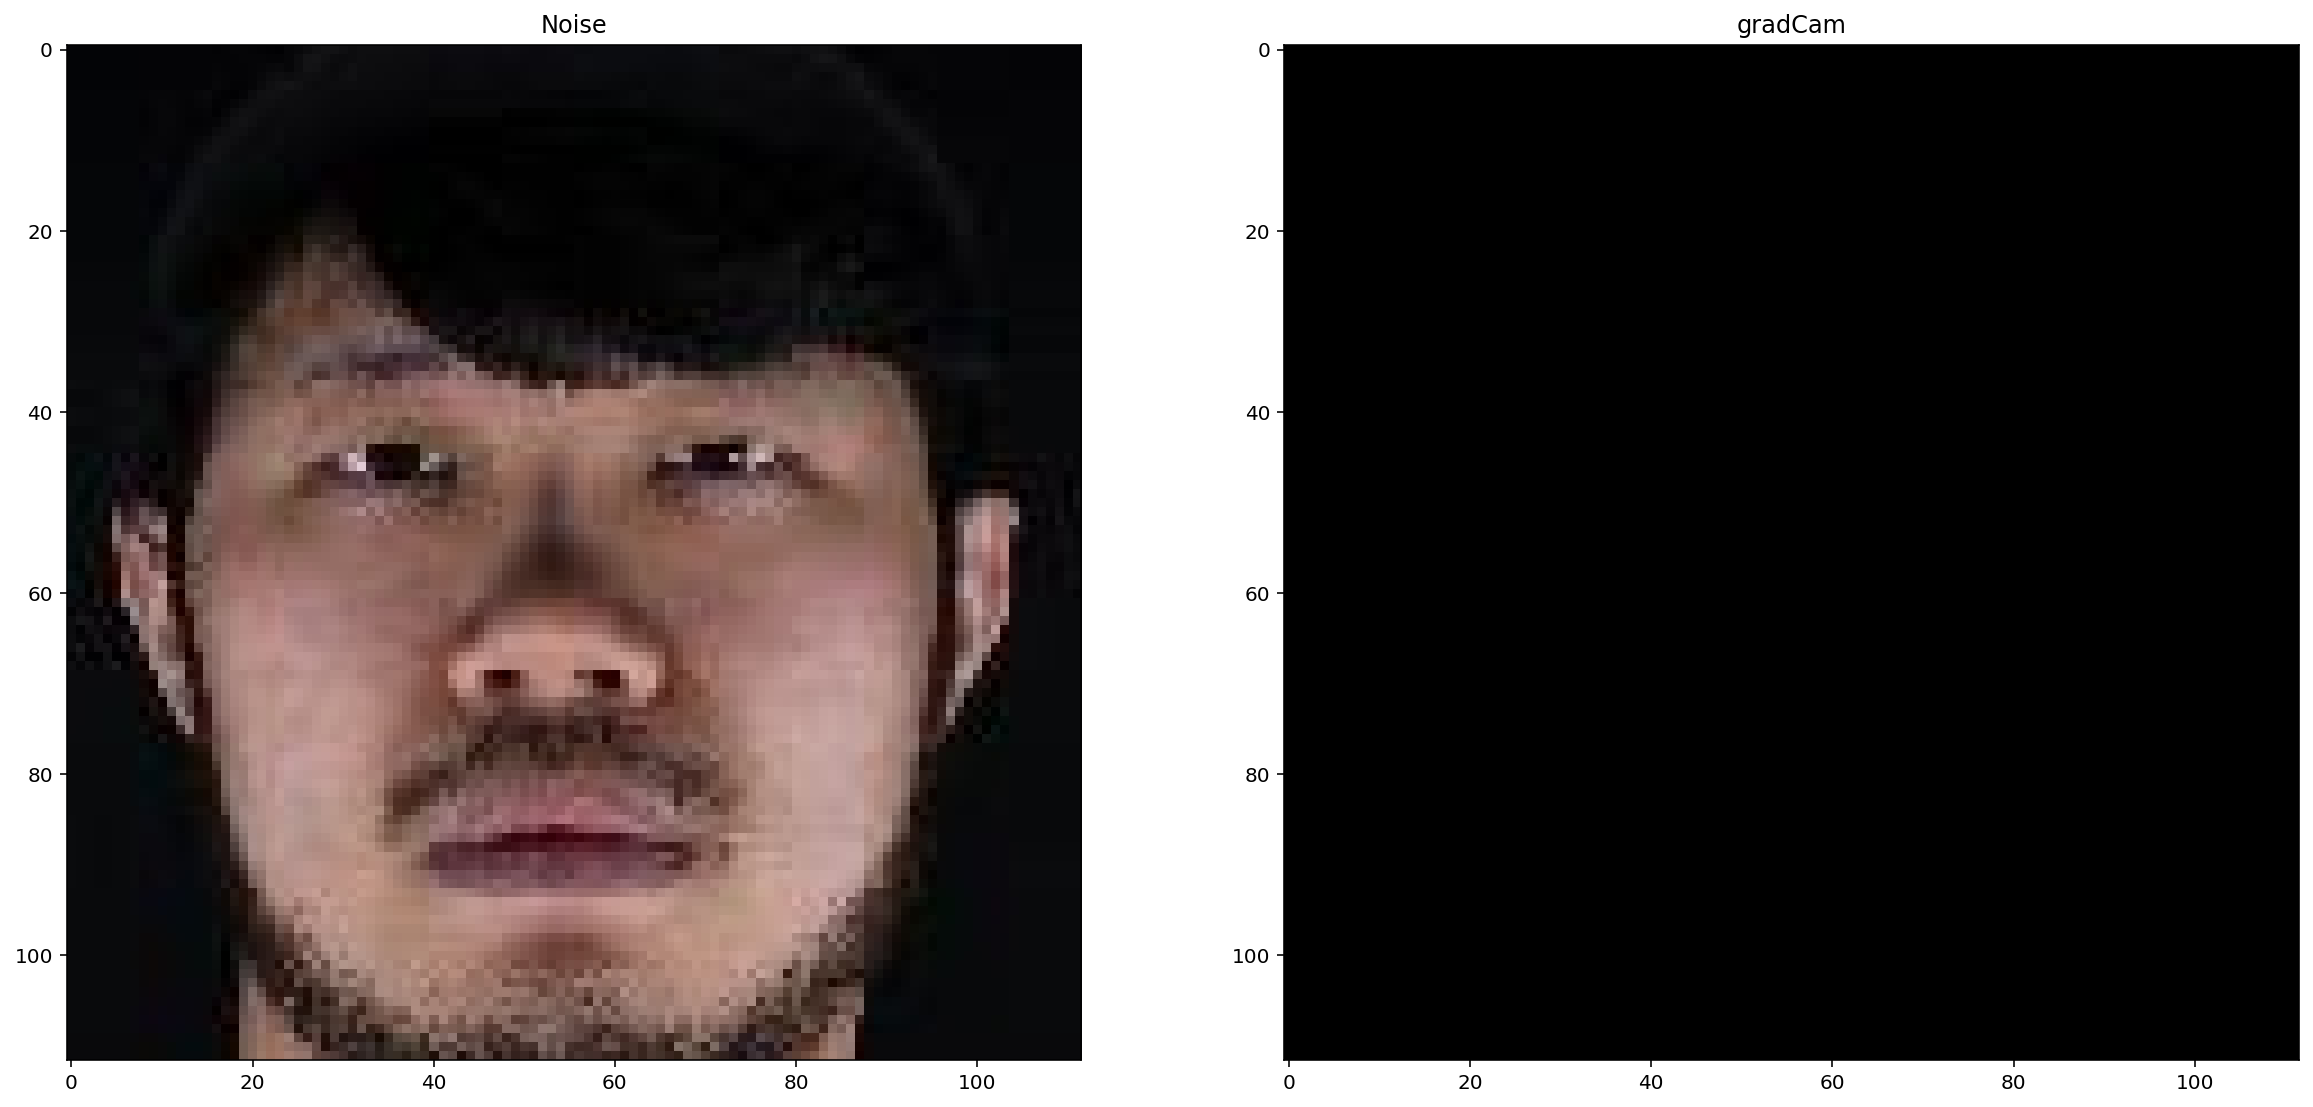

In [ ]:
img = Image.open("/content/drive/MyDrive/Lab/gradCam_range.png")
imgArray = np.asarray(img)
dst1 = cv2.inRange(imgArray, (80, 0, 0), (225, 200, 100)) # B : 0 ~ 150, G : 0 ~ 150, R : 100 ~ 255
img_result = cv2.bitwise_and(imgArray, imgArray, mask = dst1)
fig = plt.figure(figsize=(20, 20))
rows = 1; cols = 2

ax1 = fig.add_subplot(rows, cols, 1)
ax1.set_title('Noise')
image1 = ax1.imshow(imgArray)

ax2 = fig.add_subplot(rows, cols, 2)
ax2.set_title('gradCam')
image2 = ax2.imshow(img_result, cmap="gray")

In [ ]:
model.summary()

Model: "functional_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 112, 112, 3)]     0         
                                                                 
 block0_conv0 (Conv2D)       (None, 112, 112, 64)      1792      
                                                                 
 block0_conv1 (Conv2D)       (None, 112, 112, 64)      36928     
                                                                 
 block0_pooling (MaxPooling2  (None, 56, 56, 64)       0         
 D)                                                              
                                                                 
 block1_conv0 (Conv2D)       (None, 56, 56, 128)       73856     
                                                                 
 block1_conv1 (Conv2D)       (None, 56, 56, 128)       147584    
                                                      

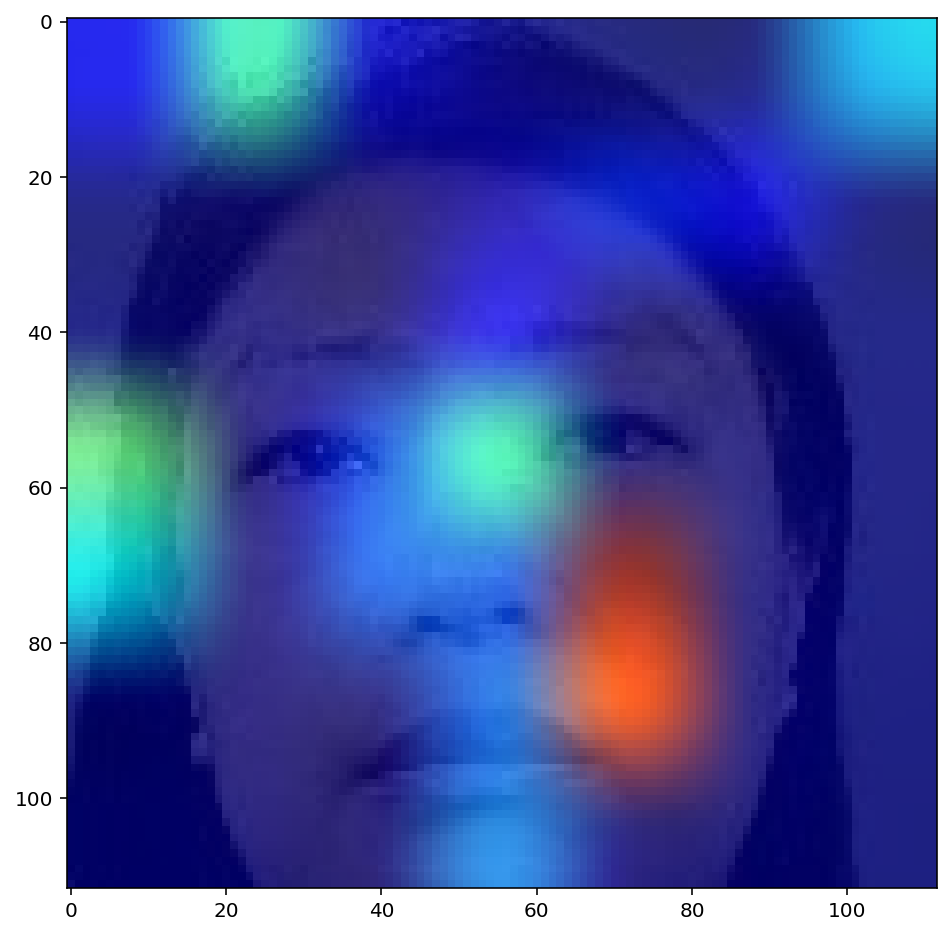

In [12]:
from PIL import Image

img_array = np.reshape(train_data[997], (1, 112, 112, 3))
heatmap = make_gradcam_heatmap(img_array, model, 'block4_conv2')
gradArr = gradCam_Array(img_array[0], heatmap)
plt.imshow(gradArr)
plt.savefig("cam.png", bbox_inches='tight', pad_inches=0)

# 새 섹션

In [ ]:
dst1 = cv2.inRange(img, (0, 0, 0), (300, 300, 150)) # B : 0 ~ 150, G : 0 ~ 150, R : 100 ~ 255
img_result = cv2.bitwise_and(img, img, mask = dst1)



  0%|          | 0/13 [00:00<?, ?it/s]

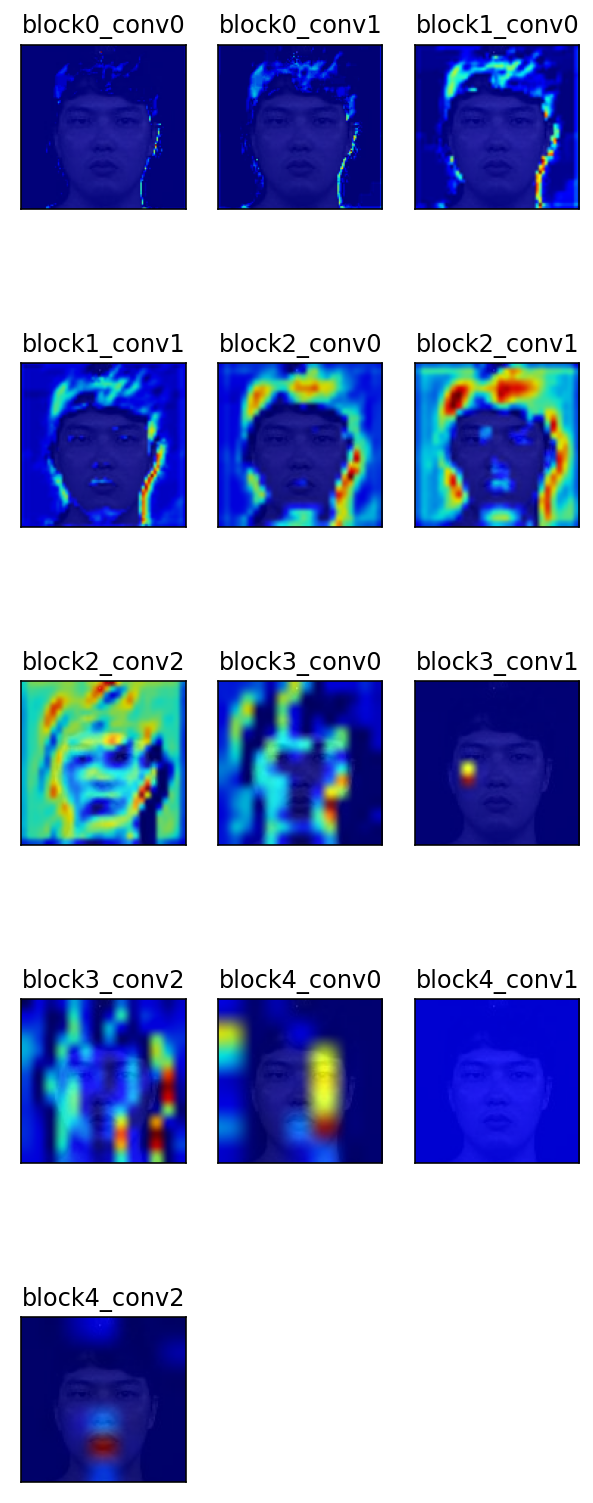

In [ ]:
from tqdm.notebook import tqdm

fig = plt.figure(figsize=(5, 20))
rows = 7; cols = 3

for i in tqdm(range(len(layers))):
    ax1 = fig.add_subplot(rows, cols, i+1)
    ax1.set_title(layers[i])
    img_array = np.reshape(train_data[0], (1, 112, 112, 3))
    heatmap = make_gradcam_heatmap(img_array, model, layers[i])
    gradArr = gradCam_Array(img_array[0], heatmap)
    ax1.axes.xaxis.set_visible(False)
    ax1.axes.yaxis.set_visible(False)
    ax1.imshow(gradArr)

In [ ]:
def add_noise(clean, noise_factor=0.85):
    make_noise = np.random.normal()
    set_noise = noise_factor * make_noise
    noisy = clean + set_noise
    return float(noisy)

In [ ]:
train_min_noisy = []

for data in tqdm(train_data, total=len(train_data)):
    img_array = data.reshape(1,112,112,3)
    heatmap = make_gradcam_heatmap(img_array, model, layers[-1])
    gradArr = gradCam_Array(img_array[0], heatmap)
    dst1 = cv2.inRange(gradArr, (0, 0, 0), (300, 300, 97)) # B : 0 ~ 150, G : 0 ~ 150, R : 100 ~ 255

    noise_idx = [[(lambda x : 0 if x == 0 else 1)(j) for j in i] for i in dst1]
    R, G, B = split_channel(data)

    R = np.array([[(lambda x : add_noise(R[i][j]) if x else R[i][j])(noise_idx[i][j]) for j in range(112)] for i in range(112)]).reshape((112, 112, 1))
    G = np.array([[(lambda x : add_noise(G[i][j]) if x else G[i][j])(noise_idx[i][j]) for j in range(112)] for i in range(112)]).reshape((112, 112, 1))
    B = np.array([[(lambda x : add_noise(B[i][j]) if x else B[i][j])(noise_idx[i][j]) for j in range(112)] for i in range(112)]).reshape((112, 112, 1))

    resultArray = np.concatenate((R, G, B), axis=2)
    train_min_noisy.append(resultArray)

train_min_noisy = np.array(train_min_noisy)
train_min_noisy.shape

  0%|          | 0/13500 [00:00<?, ?it/s]

(13500, 112, 112, 3)

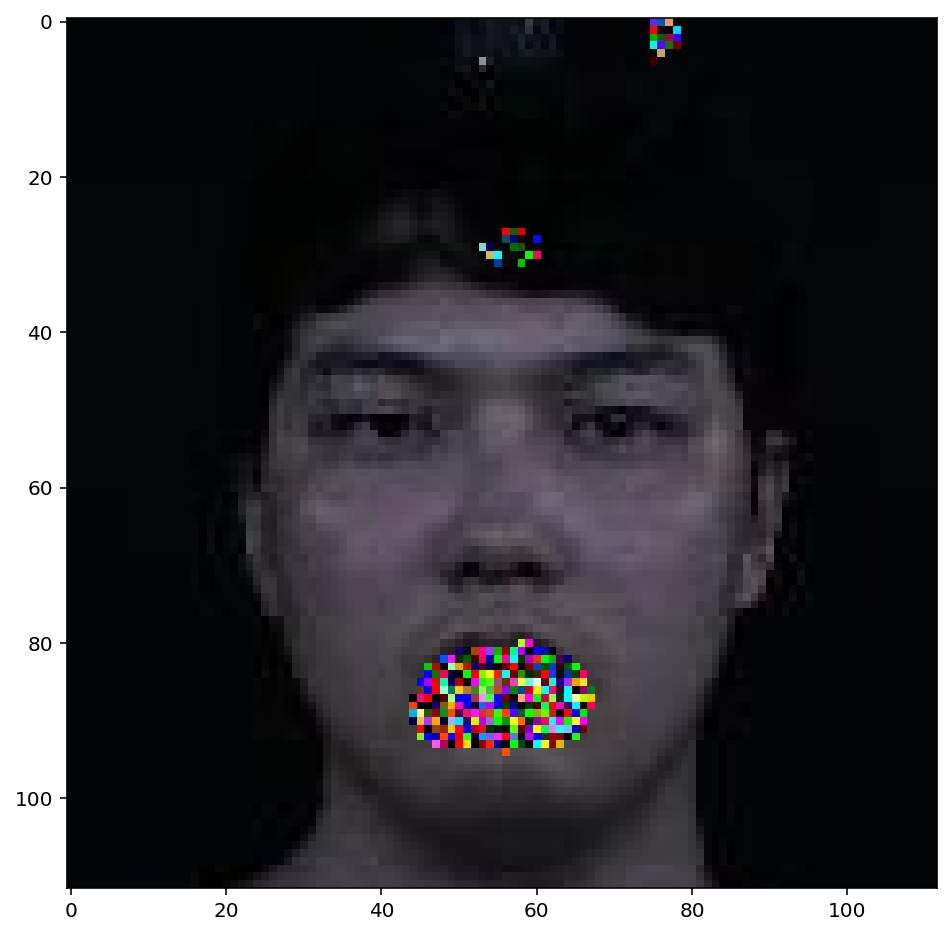

In [ ]:
plt.imshow(train_min_noisy[0])

In [ ]:
np.save('/content/gdrive/MyDrive/Lab/train_noisy_min_list.npy', train_min_noisy)

In [ ]:
from google.colab import files
files.download('train_noisy_min_list.npy')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!cp -r '/content/train_noisy_min_list.npy' '/content/gdrive/MyDrive/Lab'

In [ ]:
os.getcwd()

'/content'

In [ ]:
np.min(train_data), np.max(train_data)

(0.0, 1.0)

In [ ]:
backup = train_min_noisy.copy()

In [ ]:
train_min_noisy = backup.copy()

In [ ]:
a, n = 0, 0

for i in tqdm(train_min_noisy, total=len(train_min_noisy)):
  a, n = np.max(i), np.min(i)

print(a, n)

  0%|          | 0/13500 [00:00<?, ?it/s]

2.906705443307689 -2.632854253626918


In [ ]:
np.min(train_min_noisy), np.max(train_min_noisy)

(-4.830687010726669, 5.160995552527778)

In [ ]:
train_min_noisy = (train_min_noisy - n) / (a - n)
np.min(train_min_noisy), np.max(train_min_noisy)


(-0.0, 1.0)

In [ ]:
np.save('train_noisy_min_list_nor', train_min_noisy)

In [ ]:
train_min_noisy = (train_min_noisy) / (5.899636358296192)
np.min(train_min_noisy), np.max(train_min_noisy)

(0.0, 0.8990967043483359)

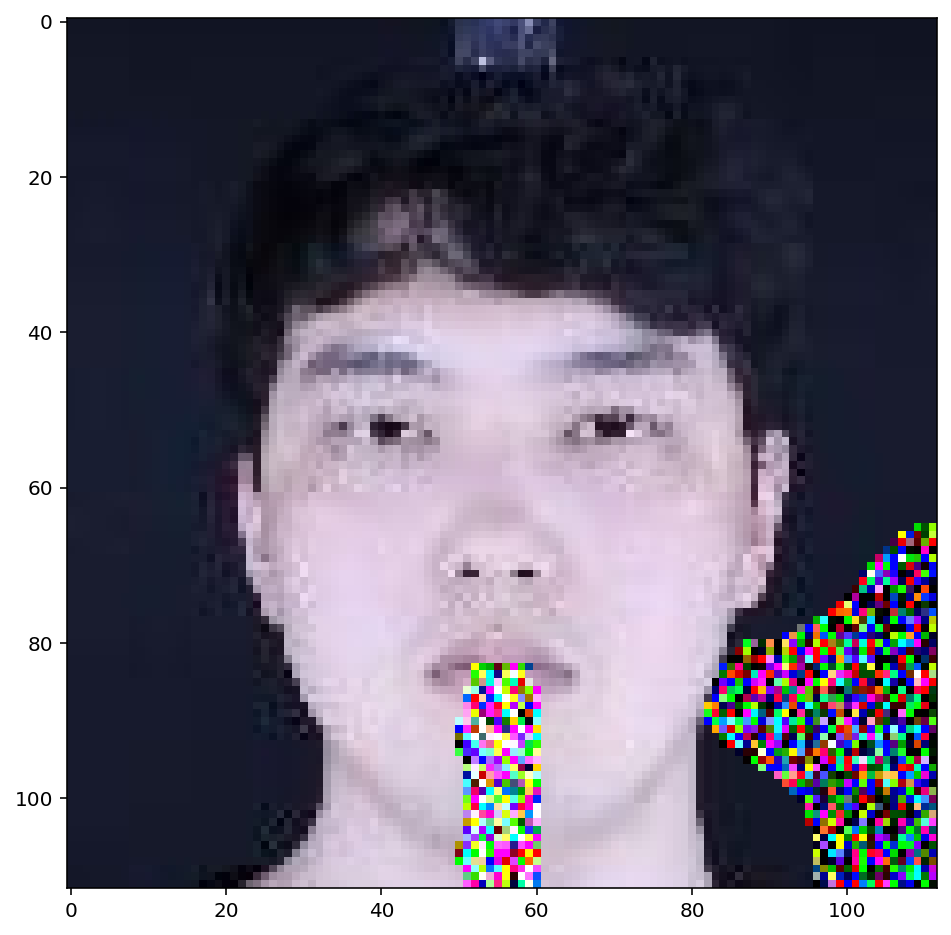

In [ ]:
plt.imshow(train_min_noisy[2])

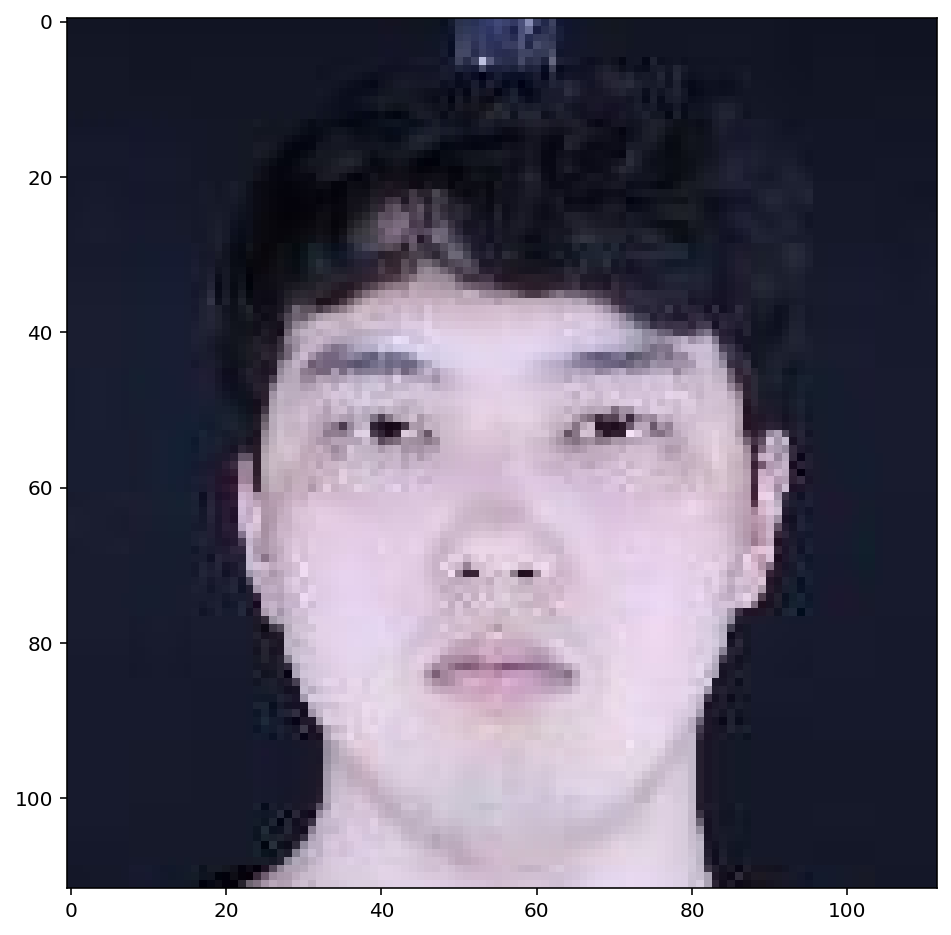

In [ ]:
plt.imshow(train_data[2])

In [ ]:
np.save('/content/drive/MyDrive/Lab/train_noisy_min_data', train_min_noisy)

  0%|          | 0/79 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:993: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)


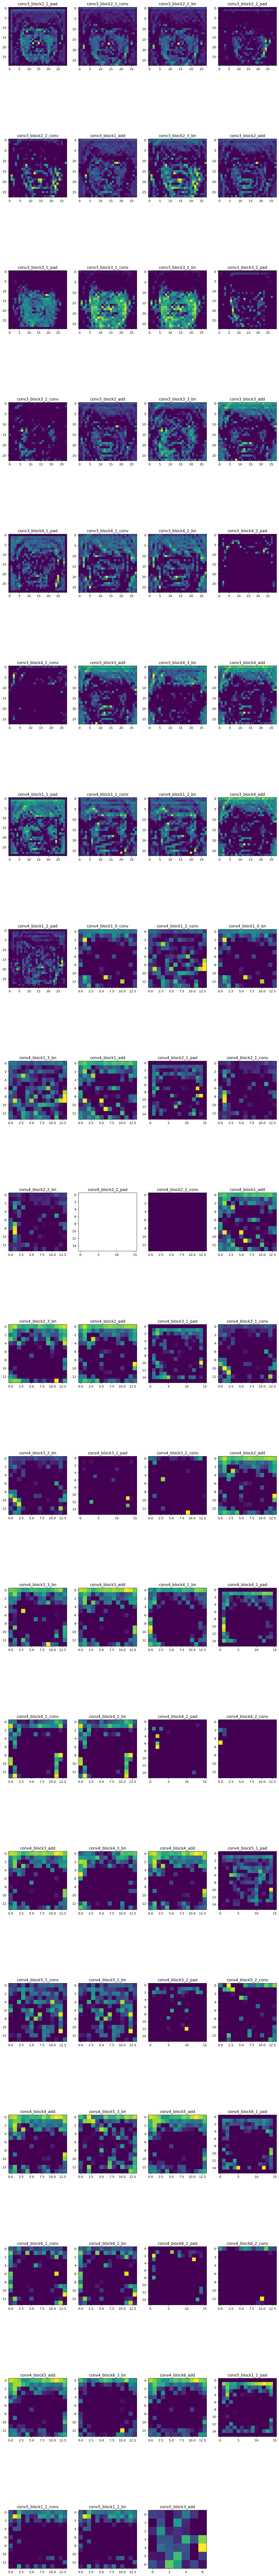

In [ ]:
img = train_data[523]
img_array = img.reshape(1,112,112,3)

fig = plt.figure(figsize=(15, 150))
rows = 20; cols = 4
for i in tqdm(range(1, 80)):
  heatmap = make_gradcam_heatmap(img_array, model, layers[i-1])
  ax = fig.add_subplot(rows, cols, i)
  ax.set_title(layers[i-1])
  ax.imshow(heatmap)

fig.show()


In [ ]:
img = train_data[0]
img_array = img.reshape(1,112,112,3)

fig = plt.figure(figsize=(15, 150))
rows = 20; cols = 4
for i in tqdm(range(1, 80)):
  heatmap = make_gradcam_heatmap(img_array, model, layers[i-1])
  ax = fig.add_subplot(rows, cols, i)
  ax.set_title(layers[i-1])
  ax.imshow(gradCam_Array(img_array[0], heatmap))

fig.show()


In [ ]:
trian_min_noisy = []

for data in train_data:
  img = train_data[74]
  img_array = img.reshape(1,112,112,3)

  fig = plt.figure(figsize=(15, 150))
  rows = 20; cols = 4
  for i in tqdm(range(1, 80)):
    heatmap = make_gradcam_heatmap(img_array, model, layers[i-1])
    ax = fig.add_subplot(rows, cols, i)
    ax.set_title(layers[i-1])
    ax.imshow(gradCam_Array(img_array[0], heatmap))


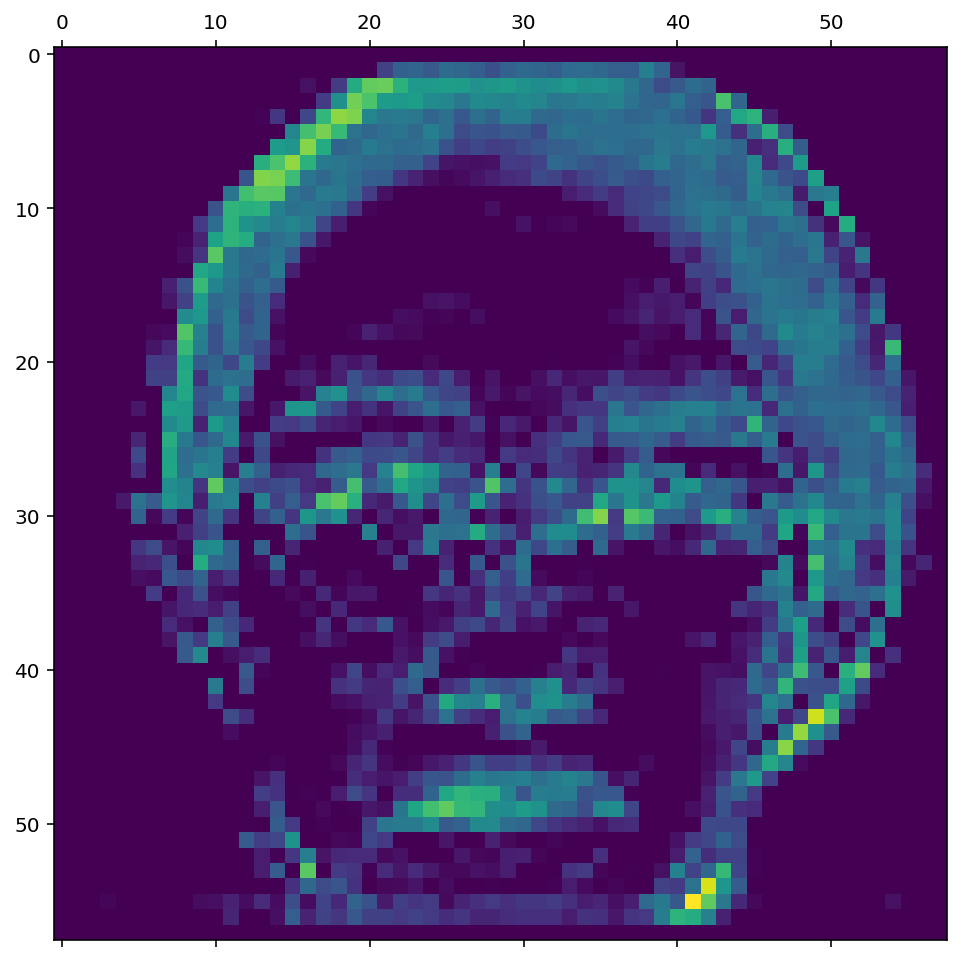

(112, 112, 3)


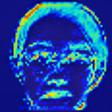

In [ ]:
# conv5_block1_add, 
img = train_data[195]
img_array = img.reshape(1,112,112,3)

heatmap = make_gradcam_heatmap(img_array, model, "conv3_block1_1_pad")
plt.matshow(heatmap)
plt.show()
save_and_display_gradcam(img, heatmap)

In [ ]:
# layer_name = 'embedding'
# e_model = keras.Model(inputs=model.input,
#                       outputs=model.get_layer(layer_name).output)

In [ ]:
def add_noise(clean, noise_factor=0.1):
    noisy = clean * np.random.normal(1)
    return float(noisy)

In [ ]:
train_512data = []
idx = 0
for data, label in tqdm(zip(train_data, train_label), total=len(train_data)):
    
    img_path = 'C:\\Users\\KwonJiHun\\1_folder\\4_lab\\3_jis\\data' + str(idx) + '.jpg'
    plt.imsave(img_path, data)
    img_array = get_img_array(img_path, size=(112,112,3))
    
    heatmap = make_gradcam_heatmap(img_array, model, "conv3_block3_add")
    camArray = gradCam_Array(data, heatmap)
    
    dst1 = cv2.inRange(camArray, (80, 0, 0), (225, 100, 110)) # B : 0 ~ 150, G : 0 ~ 150, R : 100 ~ 255
    noise_idx = [[1 for i in range(112)] for j in range(112)]
    for i in range(112):
        for j in range(112):
            if (dst1[i][j] == 0):
                noise_idx[i][j] = 0
    
    R, G, B = split_channel(data)

    for i in range(112):
        for j in range(112):
            if (noise_idx[i][j]):
                R[i][j] = add_noise(R[i][j])
                G[i][j] = add_noise(G[i][j])
                B[i][j] = add_noise(B[i][j])

    resultArray = np.array([R, G, B])
    resultArray = np.swapaxes(resultArray, 0, 2)
    resultArray = np.swapaxes(resultArray, 0, 1)
    train_512data.append(resultArray)
    idx += 1

train_512data = np.array(train_512data)
train_512data.shape

  0%|          | 0/13500 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
train_512data = np.array(train_512data)

In [ ]:
train_512data.shape

(198, 112, 112, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


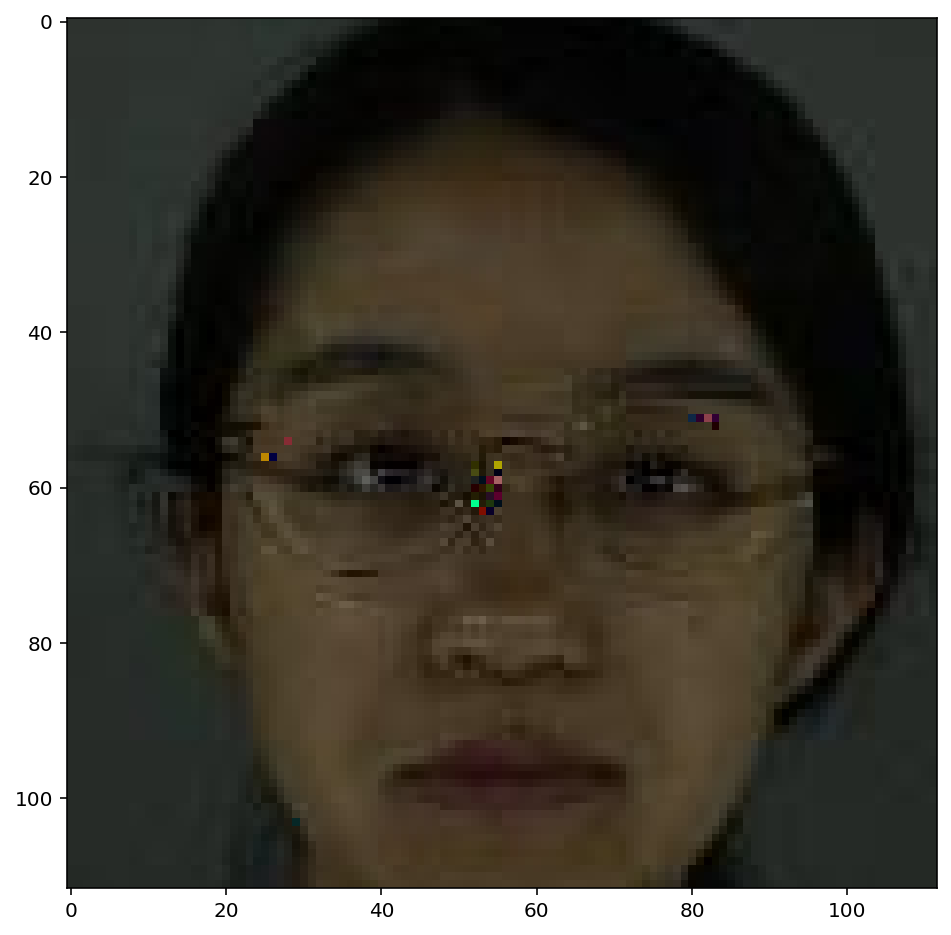

In [ ]:
plt.imshow(train_512data[195])

In [ ]:
np.save('train_noise_data', train_512data) 

In [ ]:
val_512data = []
idx = 0
for data, label in tqdm(zip(val_data, val_label), total=len(val_data)):
    
    img_path = 'C:\\Users\\chosun\\연구\\train_data\\' + str(idx) + '.jpg'
    plt.imsave(img_path, data)
    img_array = get_img_array(img_path, size=(112,112,3))
    
    emodelheatmap = make_gradcam_heatmap({"input_x":img_array,"input_y":train_label[0]}, e_model, "add_128")
    camArray = gradCam_Array(data, emodelheatmap)
    
    dst1 = cv2.inRange(camArray, (80, 0, 0), (225, 100, 110)) # B : 0 ~ 150, G : 0 ~ 150, R : 100 ~ 255
    noise_idx = [[1 for i in range(112)] for j in range(112)]
    for i in range(112):
        for j in range(112):
            if (dst1[i][j] == 0):
                noise_idx[i][j] = 0
    
    R, G, B = split_channel(data)

    for i in range(112):
        for j in range(112):
            if (noise_idx[i][j]):
                R[i][j] = add_noise(R[i][j])
                G[i][j] = add_noise(G[i][j])
                B[i][j] = add_noise(B[i][j])

    resultArray = np.array([R, G, B])
    resultArray = np.swapaxes(resultArray, 0, 2)
    resultArray = np.swapaxes(resultArray, 0, 1)
        
#     fig = plt.figure(figsize=(20, 20))
#     rows = 1; cols = 2

#     ax1 = fig.add_subplot(rows, cols, 1)
#     ax1.set_title('Noise')
#     image1 = ax1.imshow(camArray)

#     ax2 = fig.add_subplot(rows, cols, 2)
#     ax2.set_title('gradCam')
#     image2 = ax2.imshow(resultArray)
#     break
    val_512data.append(resultArray)
    idx += 1

val_512data = np.array(val_512data)
val_512data.shape

In [ ]:
test_512data = []
idx = 0
for data, label in tqdm(zip(test_data, test_label), total=len(test_data)):
    
    img_path = 'C:\\Users\\chosun\\연구\\train_data\\' + str(idx) + '.jpg'
    plt.imsave(img_path, data)
    img_array = get_img_array(img_path, size=(112,112,3))
    
    emodelheatmap = make_gradcam_heatmap({"input_x":img_array,"input_y":train_label[0]}, e_model, "add_128")
    camArray = gradCam_Array(data, emodelheatmap)
    
    dst1 = cv2.inRange(camArray, (80, 0, 0), (225, 100, 110)) # B : 0 ~ 150, G : 0 ~ 150, R : 100 ~ 255
    noise_idx = [[1 for i in range(112)] for j in range(112)]
    for i in range(112):
        for j in range(112):
            if (dst1[i][j] == 0):
                noise_idx[i][j] = 0
    
    R, G, B = split_channel(data)

    for i in range(112):
        for j in range(112):
            if (noise_idx[i][j]):
                R[i][j] = add_noise(R[i][j])
                G[i][j] = add_noise(G[i][j])
                B[i][j] = add_noise(B[i][j])

    resultArray = np.array([R, G, B])
    resultArray = np.swapaxes(resultArray, 0, 2)
    resultArray = np.swapaxes(resultArray, 0, 1)
        
#     fig = plt.figure(figsize=(20, 20))
#     rows = 1; cols = 2

#     ax1 = fig.add_subplot(rows, cols, 1)
#     ax1.set_title('Noise')
#     image1 = ax1.imshow(camArray)

#     ax2 = fig.add_subplot(rows, cols, 2)
#     ax2.set_title('gradCam')
#     image2 = ax2.imshow(resultArray)
#     break
    test_512data.append(resultArray)
    idx += 1

test_512data = np.array(test_512data)
test_512data.shape

In [ ]:
np.save('val_noise_data', val_512data) 
np.save('test_noise_data', test_512data) 

In [ ]:
import numpy as np

In [ ]:
arr = np.arange(37632).reshape((1,112,112,3))
arr = np.concatenate((arr, arr), axis=0)
arr.shape

(2, 112, 112, 3)